Nlp project code

Team-15

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install ekphrasis

In [1]:
import pandas as pd

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from tqdm import tqdm
from sklearn import utils
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import codecs
from nltk.corpus import stopwords
import string
from scipy import sparse
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from math import log
import operator

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.spellcorrect import SpellCorrector

## for bag-of-words
from sklearn import feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for word embedding
import gensim
import gensim.downloader as gensim_api

from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import preprocessing
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from mlxtend.plotting import plot_confusion_matrix
from keras import datasets, layers, models, losses

In [2]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    # annotate={"hashtag", "allcaps", "elongated", "repeated",
    #     'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    # corpus from which the word statistics are going to be used 
    # for spell correction
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons])

C:\Users\SK\anaconda3\lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...
Reading english - 2grams ...


C:\Users\SK\anaconda3\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...


In [3]:
df = pd.read_csv('agr_en_train.csv', encoding='utf-8',header=None)
df.drop([0],axis=1,inplace=True)
df[2] = df[2].map({'NAG': 0, 'CAG': 1,'OAG': 2})
df

,1,2
0,Well said sonu..you have courage to stand agai...,2
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",0
2,"Now question is, Pakistan will adhere to this?",2
3,Pakistan is comprised of fake muslims who does...,2
4,"??we r against cow slaughter,so of course it w...",0
...,...,...
11994,They belong to you flight dirty terrorist coun...,2
11995,"Really motivating programme, congratulations t...",0
11996,fabricated news,2
11997,What's wrong with you secular idiots,2


In [4]:
df1 = pd.read_csv('agr_en_dev.csv', encoding='utf-8',header=None)
df1.drop([0],axis=1,inplace=True)
df1[2] = df1[2].map({'NAG': 0, 'CAG': 1,'OAG': 2})
df1

,1,2
0,The quality of re made now makes me think it i...,1
1,@siva \nHow is ur mother???\nHow is ur wife???...,0
2,Also see ....hw ur RSS activist caught in Burk...,0
3,On the death of 2 jawans in LOC CROSS FIRING\n...,0
4,Modi ho ya Manmohan singh saala yeh log kuch n...,2
...,...,...
2996,Gaddaron se to yahi sahi hain.,0
2997,Just saw this news\n* read 1dt comment. \n*smi...,1
2998,U guys can crack jokes but can't take the crid...,1
2999,These media fellows have time to dissect one's...,1


In [5]:
df2 = pd.concat([df, df1],ignore_index=True)
df2

,1,2
0,Well said sonu..you have courage to stand agai...,2
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",0
2,"Now question is, Pakistan will adhere to this?",2
3,Pakistan is comprised of fake muslims who does...,2
4,"??we r against cow slaughter,so of course it w...",0
...,...,...
14995,Gaddaron se to yahi sahi hain.,0
14996,Just saw this news\n* read 1dt comment. \n*smi...,1
14997,U guys can crack jokes but can't take the crid...,1
14998,These media fellows have time to dissect one's...,1


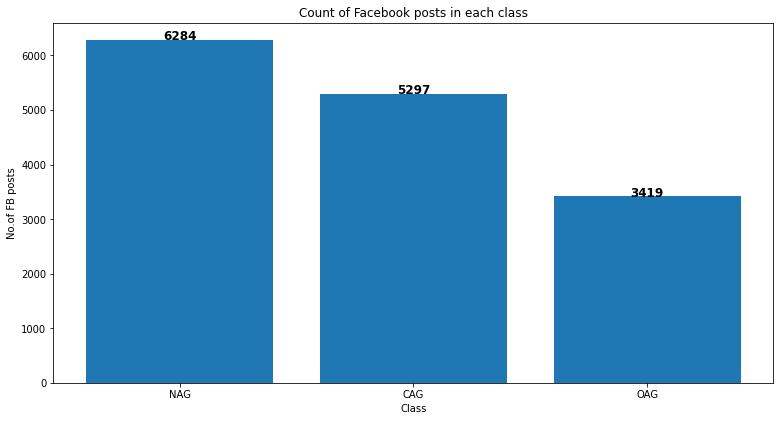

In [8]:
fig = plt.figure(figsize =(10,5))
ax = fig.add_axes([0,0,1,1])
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1,y_list[i-1],y_list[i-1],ha="center",fontsize=12,fontweight="bold")
y_count = np.bincount(df2[2])
labels = ['NAG', 'CAG', 'OAG']
ax.bar(labels,y_count)
add_value_label(labels,y_count)
ax.set_xlabel('Class')
ax.set_ylabel('No.of FB posts')
ax.set_title('Count of Facebook posts in each class')
plt.show()

In [6]:
corpus = df2[1]
corpus

0        Well said sonu..you have courage to stand agai...
1        Most of Private Banks ATM's Like HDFC, ICICI e...
2           Now question is, Pakistan will adhere to this?
3        Pakistan is comprised of fake muslims who does...
4        ??we r against cow slaughter,so of course it w...
                               ...                        
14995                       Gaddaron se to yahi sahi hain.
14996    Just saw this news\n* read 1dt comment. \n*smi...
14997    U guys can crack jokes but can't take the crid...
14998    These media fellows have time to dissect one's...
14999    Middle class is suffering, but most affected a...
Name: 1, Length: 15000, dtype: object

In [7]:
def clean_data(corpus):
    new_corp = []
    # spell correct
    print("------ Correcting Spellings ------")
    for i in tqdm(range(len(corpus))):
        t = text_processor.pre_process_doc(corpus[i])
        t = [sp.correct(word) for word in t if word not in string.punctuation]
        new_corp.append(" ".join(t))
    new_corp2 = []
    # lemmatize
    print("----- Lemmatizing Text -----")
    for i in tqdm(range(len(corpus))):
        t = new_corp[i].split(" ")
        to_add = []
        for i in t:
            if i not in stop_words:
                to_add.append(wordnet_lemmatizer.lemmatize(i))
        new_corp2.append(" ".join(to_add))
    return new_corp2

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
sp = SpellCorrector(corpus="english") 
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

lemmatized_data = clean_data(corpus)

all_words = set()
for i in range(len(corpus)):
    t = lemmatized_data[i].split(" ")
    all_words |= set(t)

all_words = list(all_words)

new_corp = lemmatized_data

Reading english - 1grams ...
------ Correcting Spellings ------


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [06:20<00:00, 39.45it/s]


----- Lemmatizing Text -----


100%|██████████████████████████████████████████████████████████████████████████| 15000/15000 [00:04<00:00, 3441.15it/s]


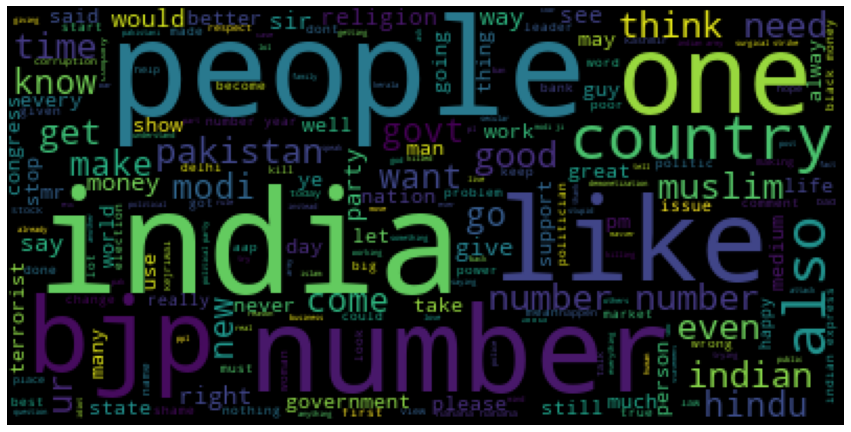

In [13]:
from wordcloud import WordCloud

text = " ".join(review for review in new_corp)
#print(len(text))
wordcloud = WordCloud(stopwords=stop_words).generate(text)

fig = plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(new_corp, df2[2], test_size=0.2, random_state=12)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
x_vec = vectorizer.fit_transform(x_train)
dic_vocabulary = vectorizer.vocabulary_
x_vec.shape

(12000, 10000)

Text(0.5, 1.0, 'Sparse Matrix Sample')

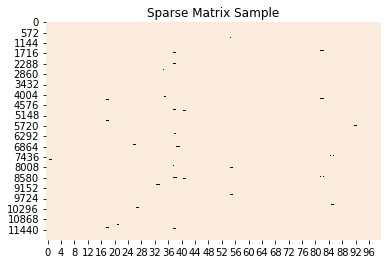

In [16]:
import seaborn as sns
sns.heatmap(x_vec.todense()[:,np.random.randint(0,x_vec.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [17]:
word = "happy"
dic_vocabulary[word]

3695

In [18]:
x_names = vectorizer.get_feature_names()
p_value_limit = 0.75
df_features = pd.DataFrame()
for cat in np.unique(y_train):
    chi2, p = feature_selection.chi2(x_vec, y_train==cat)
    df_features = df_features.append(pd.DataFrame({"feature":x_names, "score":1-p, "y":cat}))
    df_features = df_features.sort_values(["y","score"], ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
x_names = df_features["feature"].unique().tolist()
print("No.of feature after feature selection: " , len(x_names))

for cat in np.unique(y_train):
    print("# {}:".format(cat))
    print("  . selected features:",len(df_features[df_features["y"]==cat]))
    print("  . top features:", ",".join(
df_features[df_features["y"]==cat]["feature"].values[:10]))
    print(" ")

No.of feature after feature selection:  2846
# 0:
  . selected features: 1814
  . top features: nice,hi,anuj,number,nifty,muslim,stock,market,view,tata
 
# 1:
  . selected features: 960
  . top features: nice,hi,anuj,nifty,puppy,view,tata,bjp,number,buy
 
# 2:
  . selected features: 1108
  . top features: idiot,shame,stupid,bloody,muslim,terrorist,moron,hell,dog,hindu
 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(vocabulary=x_names)
X_train = vectorizer.fit_transform(x_train)
dic_vocabulary = vectorizer.vocabulary_

In [20]:
X_train.shape

(12000, 2846)

Text(0.5, 1.0, 'Sparse Matrix Sample')

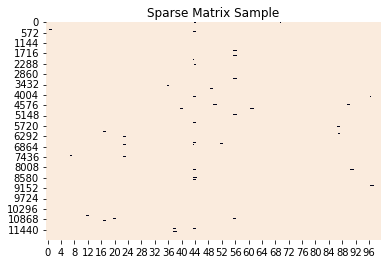

In [21]:
import seaborn as sns
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

## Using ML Models 

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", clf)])
model["classifier"].fit(X_train, y_train)

y_pred = model.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[902 267  78]
 [409 516 131]
 [144 287 266]]
              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1247
           1       0.48      0.49      0.49      1056
           2       0.56      0.38      0.45       697

    accuracy                           0.56      3000
   macro avg       0.55      0.53      0.54      3000
weighted avg       0.56      0.56      0.55      3000



In [23]:
classifier = naive_bayes.MultinomialNB()
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
nb_pred = model.predict(x_test)
predicted_prob = model.predict_proba(x_test)

print(confusion_matrix(y_test,nb_pred))
print(classification_report(y_test,nb_pred))

[[871 320  56]
 [340 602 114]
 [132 363 202]]
              precision    recall  f1-score   support

           0       0.65      0.70      0.67      1247
           1       0.47      0.57      0.51      1056
           2       0.54      0.29      0.38       697

    accuracy                           0.56      3000
   macro avg       0.55      0.52      0.52      3000
weighted avg       0.56      0.56      0.55      3000



In [24]:
from lime import lime_text

i = 16
txt_instance = x_test[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", nb_pred[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show visulaization
explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explained = explainer.explain_instance(txt_instance, model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: 0 --> Pred: 1 | Prob: 0.53


In [25]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
lr_pred = model.predict(x_test)
predicted_prob = model.predict_proba(x_test)

print(confusion_matrix(y_test,lr_pred))
print(classification_report(y_test,lr_pred))

[[883 290  74]
 [371 516 169]
 [131 288 278]]
              precision    recall  f1-score   support

           0       0.64      0.71      0.67      1247
           1       0.47      0.49      0.48      1056
           2       0.53      0.40      0.46       697

    accuracy                           0.56      3000
   macro avg       0.55      0.53      0.54      3000
weighted avg       0.56      0.56      0.55      3000



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [26]:
pip install lime

## Using DL models 

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [28]:
num_words = 8000
embed_dim = 64
tokenizer = Tokenizer(num_words=num_words,oov_token = "<oov>")
tokenizer.fit_on_texts(new_corp)
word_index=tokenizer.word_index
sequences = tokenizer.texts_to_sequences(new_corp)
length=[]
for i in sequences:
    length.append(len(i))
print(len(length))

15000


In [29]:
pad_length = 50
sequences = pad_sequences(sequences, maxlen = pad_length, truncating = 'pre', padding = 'post')
sequences.shape

(15000, 50)

In [30]:
train_x,test_x,train_y,test_y =  train_test_split(sequences,df2[2],test_size = 0.2,random_state=12)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(12000, 50)
(3000, 50)
(12000,)
(3000,)


#### RNN 

In [31]:
from keras.layers import Dense, Embedding, Dropout , Activation, Flatten, SimpleRNN
from keras.layers import GlobalMaxPool1D
from keras.models import Model, Sequential
import tensorflow as tf

max_len = 50
RNN = Sequential([Embedding(10000, 100, input_length = max_len),
                   SimpleRNN(128, return_sequences = True),
                   GlobalMaxPool1D(),
                   Dense(20,activation = 'relu'),
                   Dropout(0.2),
                   Dense(3,activation = 'softmax')])
RNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 50, 128)           29312     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 20)                2580      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 63        
                                                        

In [32]:
history = RNN.fit(x = train_x, y = train_y, epochs = 10,validation_split = 0.2)

Epoch 1/10
300/300 [==============================] - 35s 106ms/step - loss: 1.0572 - accuracy: 0.4165 - val_loss: 1.0330 - val_accuracy: 0.4708
Epoch 2/10
300/300 [==============================] - 28s 95ms/step - loss: 0.9777 - accuracy: 0.5086 - val_loss: 1.0215 - val_accuracy: 0.4658
Epoch 3/10
300/300 [==============================] - 17s 55ms/step - loss: 0.8926 - accuracy: 0.5766 - val_loss: 0.9793 - val_accuracy: 0.5079
Epoch 4/10
300/300 [==============================] - 17s 56ms/step - loss: 0.8263 - accuracy: 0.6247 - val_loss: 0.9618 - val_accuracy: 0.5229
Epoch 5/10
300/300 [==============================] - 17s 56ms/step - loss: 0.8266 - accuracy: 0.6067 - val_loss: 1.0285 - val_accuracy: 0.4871
Epoch 6/10
300/300 [==============================] - 17s 56ms/step - loss: 0.8709 - accuracy: 0.5789 - val_loss: 1.0107 - val_accuracy: 0.4946
Epoch 7/10
300/300 [==============================] - 20s 65ms/step - loss: 0.8155 - accuracy: 0.6189 - val_loss: 0.9959 - val_accuracy

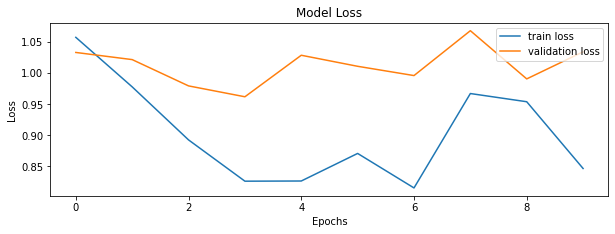

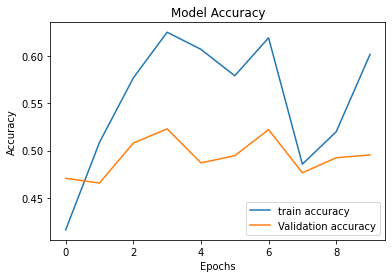

In [33]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'],loc='upper right')
plt.show()

fig.add_subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train accuracy','Validation accuracy'],loc='lower right')
plt.show()

In [34]:
# prediction
RNN_pred = np.argmax(RNN.predict(test_x), axis=-1)

In [35]:
print(confusion_matrix(test_y,RNN_pred))
print(classification_report(test_y,RNN_pred))

[[693 541  13]
 [289 708  59]
 [120 491  86]]
              precision    recall  f1-score   support

           0       0.63      0.56      0.59      1247
           1       0.41      0.67      0.51      1056
           2       0.54      0.12      0.20       697

    accuracy                           0.50      3000
   macro avg       0.53      0.45      0.43      3000
weighted avg       0.53      0.50      0.47      3000



#### LSTM 

In [36]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model

In [37]:
from sklearn.utils import class_weight

class_weights =  class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(train_y),y = train_y)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.7941234862021044, 1: 0.9431737797689225, 2: 1.4695077149155034}

In [38]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000, 100, input_length = max_len),
tf.keras.layers.Conv1D(256, 5, activation='relu'),
tf.keras.layers.MaxPooling1D(5),
tf.keras.layers.Bidirectional(LSTM(units = 32,return_sequences=True,dropout = 0.2)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation = 'relu'),
tf.keras.layers.Dense(3, activation='softmax')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           1000000   
                                                                 
 conv1d (Conv1D)             (None, 46, 256)           128256    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 256)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 9, 64)            73984     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [39]:
model.compile(optimizer=keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
   
history = model.fit(train_x,train_y,
    epochs=10,
    batch_size = 32,
    validation_split = 0.2,
    verbose =1,
    class_weight = class_weights)

Epoch 1/10
300/300 [==============================] - 18s 22ms/step - loss: 1.0001 - accuracy: 0.4711 - val_loss: 0.9217 - val_accuracy: 0.5517
Epoch 2/10
300/300 [==============================] - 6s 19ms/step - loss: 0.7840 - accuracy: 0.6397 - val_loss: 0.9343 - val_accuracy: 0.5571
Epoch 3/10
300/300 [==============================] - 5s 18ms/step - loss: 0.5179 - accuracy: 0.7837 - val_loss: 1.1201 - val_accuracy: 0.5575
Epoch 4/10
300/300 [==============================] - 5s 18ms/step - loss: 0.2862 - accuracy: 0.8860 - val_loss: 1.3589 - val_accuracy: 0.5396
Epoch 5/10
300/300 [==============================] - 6s 19ms/step - loss: 0.1647 - accuracy: 0.9349 - val_loss: 2.0480 - val_accuracy: 0.5471
Epoch 6/10
300/300 [==============================] - 5s 18ms/step - loss: 0.1006 - accuracy: 0.9643 - val_loss: 2.5050 - val_accuracy: 0.5204
Epoch 7/10
300/300 [==============================] - 5s 18ms/step - loss: 0.0783 - accuracy: 0.9700 - val_loss: 2.4968 - val_accuracy: 0.541

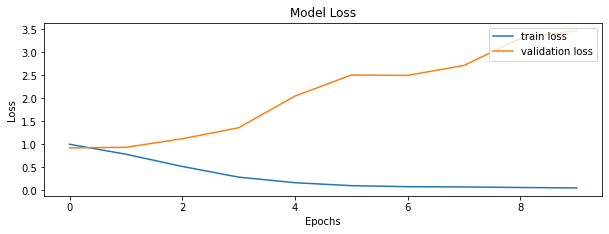

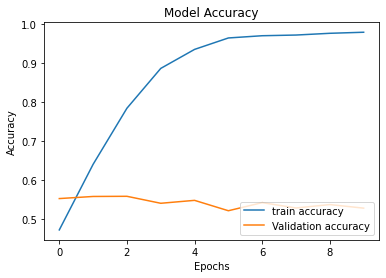

In [40]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'],loc='upper right')
plt.show()

fig.add_subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train accuracy','Validation accuracy'],loc='lower right')
plt.show()

In [41]:
# prediction
LSTM_pred = np.argmax(model.predict(test_x), axis=-1)

In [42]:
print(confusion_matrix(test_y,LSTM_pred))
print(classification_report(test_y,LSTM_pred))

[[694 446 107]
 [275 550 231]
 [107 296 294]]
              precision    recall  f1-score   support

           0       0.64      0.56      0.60      1247
           1       0.43      0.52      0.47      1056
           2       0.47      0.42      0.44       697

    accuracy                           0.51      3000
   macro avg       0.51      0.50      0.50      3000
weighted avg       0.53      0.51      0.52      3000



#### GRU 

In [43]:
from tensorflow.keras.layers import Layer, Embedding, Bidirectional, Attention, GRU, Dense, SpatialDropout1D, LSTM
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
from tensorflow.keras import backend as K

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [45]:
#GRU model

max_len = 50
model_GRU = models.Sequential()
model_GRU.add(Embedding(10000, 100, input_length = max_len))
model_GRU.add(SpatialDropout1D(0.4))
model_GRU.add(Bidirectional(GRU(256, dropout=0.05, recurrent_dropout = 0.2, return_sequences=True)))
model_GRU.add(Attention(return_sequences=False)) # receive 3D and output 2D
model_GRU.add(Dense(128, activation = 'relu'))
model_GRU.add(Dense(3, activation='softmax'))
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           1000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 512)          549888    
 nal)                                                            
                                                                 
 attention (Attention)       (None, 512)               562       
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 3)                

In [46]:
model_GRU.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [47]:
history = model_GRU.fit(x = train_x, y = train_y, epochs = 10,validation_split = 0.2,batch_size=128,verbose=1)

Epoch 1/10
75/75 [==============================] - 28s 311ms/step - loss: 1.0413 - accuracy: 0.4431 - val_loss: 0.9768 - val_accuracy: 0.5017
Epoch 2/10
75/75 [==============================] - 22s 294ms/step - loss: 0.8779 - accuracy: 0.5735 - val_loss: 0.9222 - val_accuracy: 0.5604
Epoch 3/10
75/75 [==============================] - 22s 295ms/step - loss: 0.7523 - accuracy: 0.6570 - val_loss: 0.9242 - val_accuracy: 0.5679
Epoch 4/10
75/75 [==============================] - 22s 292ms/step - loss: 0.6591 - accuracy: 0.7204 - val_loss: 0.9289 - val_accuracy: 0.5567
Epoch 5/10
75/75 [==============================] - 22s 293ms/step - loss: 0.5720 - accuracy: 0.7695 - val_loss: 1.0748 - val_accuracy: 0.5617
Epoch 6/10
75/75 [==============================] - 22s 295ms/step - loss: 0.4790 - accuracy: 0.8093 - val_loss: 1.1356 - val_accuracy: 0.5546
Epoch 7/10
75/75 [==============================] - 22s 295ms/step - loss: 0.4242 - accuracy: 0.8374 - val_loss: 1.2066 - val_accuracy: 0.5529

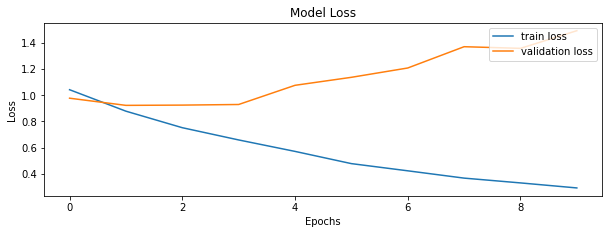

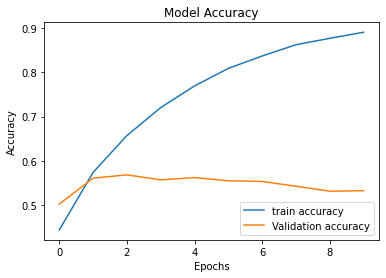

In [48]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'],loc='upper right')
plt.show()

fig.add_subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train accuracy','Validation accuracy'],loc='lower right')
plt.show()

In [49]:
# prediction
GRU_pred = np.argmax(model.predict(test_x), axis=-1)

In [50]:
print(confusion_matrix(test_y,GRU_pred))
print(classification_report(test_y,GRU_pred))

[[694 446 107]
 [275 550 231]
 [107 296 294]]
              precision    recall  f1-score   support

           0       0.64      0.56      0.60      1247
           1       0.43      0.52      0.47      1056
           2       0.47      0.42      0.44       697

    accuracy                           0.51      3000
   macro avg       0.51      0.50      0.50      3000
weighted avg       0.53      0.51      0.52      3000



# Word2Vec

In [123]:
import gensim
from gensim.models.keyedvectors import KeyedVectors

w2v = gensim_api.load("word2vec-google-news-300")

In [141]:
w2v['happy'].shape

(300,)

In [133]:
w2v.most_similar("happy")

[('glad', 0.7408890724182129),
 ('pleased', 0.6632171273231506),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286198616028),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437948942184448),
 ('proud', 0.636042058467865),
 ('delighted', 0.6272379159927368),
 ('disappointed', 0.6269949078559875),
 ('excited', 0.6247666478157043)]

In [134]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_corp)
token_corp = tokenizer.texts_to_sequences(new_corp)

In [148]:
maxlen = 10
pad_seq = pad_sequences(token_corp, maxlen=maxlen)

In [149]:
vocab_size = len(word_index) + 1
vocab_size

18849

In [150]:
embedding_layer = Embedding(input_dim=w2v.vectors.shape[0], 
                            output_dim=w2v.vectors.shape[1], 
                            weights=[w2v.vectors], 
                            input_length=pad_seq.shape[1])

In [151]:
w2v_train,w2v_test,w2v_label_train,w2v_label_test=train_test_split(pad_seq,df2[2],test_size=0.2,random_state=42)

In [152]:
w2v_label_train.shape

(12000,)

In [161]:
model=Sequential()
model.add(embedding_layer)
model.add(LSTM(100,return_sequences=False)) 
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(1,activation='softmax'))
for layer in model.layers[:1]:
    layer.trainable = False

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 300)           900000000 
                                                                 
 lstm_10 (LSTM)              (None, 100)               160400    
                                                                 
 flatten_6 (Flatten)         (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                6464      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 900,166,929
Trainable params: 166,929
No

In [162]:
# compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [163]:
# fitting the model.
model.fit(w2v_train,w2v_label_train,epochs=10,batch_size=64,validation_split=0.2)

Epoch 1/10
150/150 [==============================] - 19s 51ms/step - loss: 0.4781 - accuracy: 0.3539 - val_loss: 0.4021 - val_accuracy: 0.3487
Epoch 2/10
150/150 [==============================] - 2s 16ms/step - loss: 0.3355 - accuracy: 0.3539 - val_loss: 0.2389 - val_accuracy: 0.3487
Epoch 3/10
150/150 [==============================] - 2s 16ms/step - loss: -0.4042 - accuracy: 0.3539 - val_loss: 1.4107 - val_accuracy: 0.3487
Epoch 4/10
150/150 [==============================] - 2s 16ms/step - loss: -0.9477 - accuracy: 0.3539 - val_loss: 0.5417 - val_accuracy: 0.3487
Epoch 5/10
150/150 [==============================] - 2s 16ms/step - loss: 0.2125 - accuracy: 0.3539 - val_loss: -0.2220 - val_accuracy: 0.3487
Epoch 6/10
150/150 [==============================] - 2s 16ms/step - loss: -5.3653 - accuracy: 0.3539 - val_loss: -3.7814 - val_accuracy: 0.3487
Epoch 7/10
150/150 [==============================] - 2s 16ms/step - loss: -13.1726 - accuracy: 0.3539 - val_loss: -2.9203 - val_accurac

In [ ]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(2, 1, 1)
plt.plot(history.history_embedding['loss'])
plt.plot(history.history_embedding['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'],loc='upper right')
plt.show()

fig.add_subplot(2, 1, 2)
plt.plot(history.history_embedding['accuracy'])
plt.plot(history.history_embedding['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train accuracy','Validation accuracy'],loc='lower right')
plt.show()

In [165]:
w2v_pred =  np.argmax(model.predict(w2v_test), axis  =  1)


print(confusion_matrix(w2v_label_test,w2v_pred))
print(classification_report(w2v_label_test,w2v_pred))

[[1257    0    0]
 [1063    0    0]
 [ 680    0    0]]
              precision    recall  f1-score   support

           0       0.42      1.00      0.59      1257
           1       0.00      0.00      0.00      1063
           2       0.00      0.00      0.00       680

    accuracy                           0.42      3000
   macro avg       0.14      0.33      0.20      3000
weighted avg       0.18      0.42      0.25      3000



C:\Users\SK\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SK\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SK\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
